In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import lib, gto, scf
import pyqmc.recipes
import h5py
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/python3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


This function computes the mean-field solution and saves the results to the file specified. We recommend using the ccecp pseudopotentials for high accuracy and efficiency.

In [2]:
def mean_field(chkfile):
    mol = gto.M(atom = "O 0 0 0; H 0 -2.757 2.587; H 0 2.757 2.587", basis='ccecpccpvdz', ecp='ccecp', unit='bohr')

    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()
mean_field("h2o.hdf5")

converged SCF energy = -16.4791748386415


Now we wish to construct a Slater-Jastrow wave function and optimize its energy. This is done using the OPTIMIZE function in pyqmc.recipes. It's often helpful to do the first optimization with only a few configurations, to get close to the minimum cheaply.

In [3]:
pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj_200.hdf5",nconfig=200,max_iterations=10,verbose=True)

starting warmup
-vmc done
finished warmup
----------vmc done
descent en -16.498175841405146 0.012338018644521614  estimated sigma  1.744859329989458
descent |grad| 0.6334719580386864
----------vmc done
descent en -16.617130966953717 0.011458023483768204  estimated sigma  1.6204092208734415
descent |grad| 0.44728994062385535
----------vmc done
descent en -16.687962020979626 0.007276051165538729  estimated sigma  1.0289890238825437
descent |grad| 0.14793648074781598
----------vmc done
descent en -16.70995737936446 0.008612024650226875  estimated sigma  1.2179242059842257
descent |grad| 0.15417910564253537
----------vmc done
descent en -16.73015588840481 0.004832629308538244  estimated sigma  0.6834369910056498
descent |grad| 0.16076143828942197
----------vmc done
descent en -16.722671874842895 0.008185818165524236  estimated sigma  1.1576495068804424
descent |grad| 0.11621277085652244
----------vmc done
descent en -16.75003119558831 0.009351211105748438  estimated sigma  1.32246095703633

* Since we want to start from the previous optimization, we use the `load_parameters` command in OPTIMIZE.

* `max_iterations` reduces the number of iterations, just to keep the computation low for this example.

In [4]:
pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj_800.hdf5", load_parameters="h2o_sj_200.hdf5", nconfig=800, max_iterations=10,verbose=True)

starting warmup
-vmc done
finished warmup
----------vmc done
descent en -16.752396483904967 0.002130079443094982  estimated sigma  0.6024774474714107
descent |grad| 0.05217678323625659
----------vmc done
descent en -16.750662341884826 0.0039986332876028804  estimated sigma  1.130984285256902
descent |grad| 0.06243517359681155
----------vmc done
descent en -16.74249188821819 0.002781386542597505  estimated sigma  0.7866949141486809
descent |grad| 0.03642482355483576
----------vmc done
descent en -16.759573034240763 0.004162626342151755  estimated sigma  1.1773685256325042
descent |grad| 0.03915660479309946
----------vmc done
descent en -16.754402351387846 0.006044736954541143  estimated sigma  1.7097097964179848
descent |grad| 0.03384018628765558
----------vmc done
descent en -16.761059556001904 0.004265870883747867  estimated sigma  1.206570491825747
descent |grad| 0.04158515173865842
----------vmc done
descent en -16.764546581205515 0.0030384253286362337  estimated sigma  0.8593964616

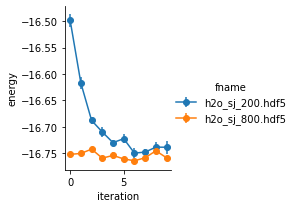

In [5]:
import seaborn as sns
df = pd.concat([pyqmc.recipes.read_opt(f"h2o_sj_{n}.hdf5") for n in [200,800]])
g = sns.FacetGrid(hue='fname',data=df)
g.map(plt.errorbar,'iteration','energy','error', marker='o')
g.add_legend()

In [8]:
for n in [200,800]:
    pyqmc.recipes.VMC("h2o.hdf5",f"h2o_sj_vmc_{n}.hdf5", load_parameters=f"h2o_sj_{n}.hdf5", nblocks=30,verbose=True)

Restarting calculation h2o_sj_vmc_200.hdf5 from step 10
------------------------------vmc done
Restarting calculation h2o_sj_vmc_800.hdf5 from step 10
------------------------------vmc done


                 fname  warmup reblock  energyecp  energyecp_err   energyee  \
0  h2o_sj_vmc_200.hdf5       1    None   1.170437       0.012254  14.141884   
1  h2o_sj_vmc_800.hdf5       1    None   1.185654       0.009058  14.107579   

   energyee_err   energyei  energyei_err  energygrad2  energygrad2_err  \
0      0.010854 -47.663124      0.033761    24.579833         0.482689   
1      0.010866 -47.648335      0.034548    24.275202         0.125150   

    energyke  energyke_err  energytotal  energytotal_err  nconfig  
0  12.249322      0.025433   -16.746102         0.002156      200  
1  12.233880      0.023708   -16.765842         0.001717      800  


Text(0, 0.5, 'energy (Ha)')

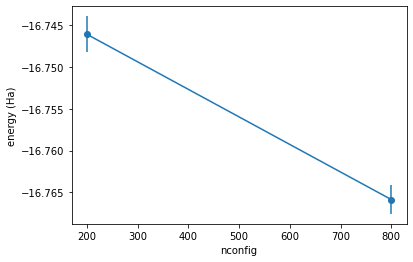

In [9]:

df = pd.DataFrame([pyqmc.recipes.read_mc_output(f"h2o_sj_vmc_{n}.hdf5") for n in [200,800]])
df['nconfig'] = [int(x.split('_')[3].replace('.hdf5','')) for x in df['fname']]
print(df)
plt.errorbar("nconfig","energytotal","energytotal_err", data=df, marker='o')
plt.xlabel("nconfig")
plt.ylabel("energy (Ha)")

In [10]:
pyqmc.recipes.DMC("h2o.hdf5",f"h2o_sj_dmc_800.hdf5", load_parameters=f"h2o_sj_800.hdf5", verbose=True)


026156644545738995
energy -16.865334831832627 e_trial -16.834186234997716 e_est -16.82534557386309 sigma(w) 0.025155535655065613
energy -16.85467623555936 e_trial -16.83710284143447 e_est -16.827311512599913 sigma(w) 0.0253421276598612
energy -16.8467626037094 e_trial -16.840367750755796 e_est -16.830120918087275 sigma(w) 0.025381714879488617
energy -16.85322809617093 e_trial -16.842496745514193 e_est -16.83157368852587 sigma(w) 0.026769537456085683
energy -16.851681144531614 e_trial -16.843903025105902 e_est -16.83276329817419 sigma(w) 0.026583323413023174
energy -16.83001491160311 e_trial -16.84312253659852 e_est -16.832609774376344 sigma(w) 0.026157072822873263
energy -16.859971431998048 e_trial -16.84690219097146 e_est -16.836117936586984 sigma(w) 0.027217314416734372
energy -16.859413149216532 e_trial -16.849697004297145 e_est -16.837350982511932 sigma(w) 0.027021541218007362
energy -16.84752073475178 e_trial -16.850018299230086 e_est -16.83786233274343 sigma(w) 0.0260176573975430

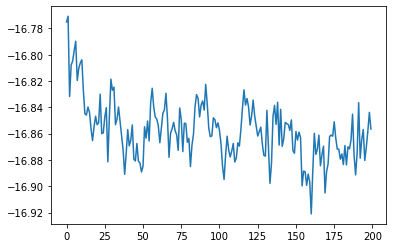

In [11]:
with h5py.File("h2o_sj_dmc_800.hdf5") as f:
    en = f['energytotal'][...]

plt.plot(en)


Text(0.5, 0, 'warmup')

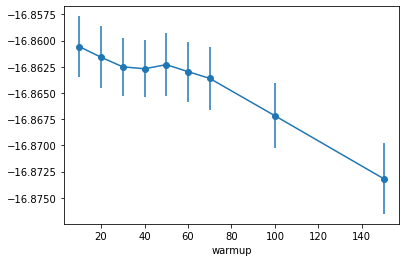

In [12]:
df = pd.DataFrame([pyqmc.recipes.read_mc_output("h2o_sj_dmc_800.hdf5", warmup=warmup, reblock=16) for warmup in [10,20,30,40,50, 60,70, 100, 150]])
plt.errorbar("warmup",'energytotal', 'energytotal_err',data=df, marker='o')
plt.xlabel("warmup")